In [1]:
cd ..

/Users/muhammadfarooq/Codebase/wood-log-detection/Pith2Bark


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from src.cv_winner import winner_model_rings
from src.damage import merge_df
from src.damage import read_damage_min_max
from src.damage import read_damage_mean

# Damage Dataset

In [3]:
rmse_url = "cv_output/ringsranking_rmse.csv"
rings_url = "cv_output/ringsranking_rings.csv"
df_ringsranking = winner_model_rings(rmse_url, rings_url)

Polar Pith Canny(blur otsu) 12.829 (subseq)


In [4]:
rmse_url = "cv_output/pine_rmse.csv"
rings_url = "cv_output/pine_rings.csv"
df_pine = winner_model_rings(rmse_url, rings_url)

Polar Pith Canny(blur triangle) 19.888 (peaks)


In [5]:
rmse_url = "cv_output/fur_rmse.csv"
rings_url = "cv_output/fur_rings.csv"
df_fur = winner_model_rings(rmse_url, rings_url)

Polar Pith Canny(blur triangle) 13.429 (peaks)


In [6]:
rmse_url = "cv_output/tracy_rmse.csv"
rings_url = "cv_output/tracy_rings.csv"
df_tracy = winner_model_rings(rmse_url, rings_url)

Polar Canny(triangle) 39.684 (peaks)


In [7]:
rmse_url = "cv_output/data_rmse.csv"
rings_url = "cv_output/data_rings.csv"
df_data = winner_model_rings(rmse_url, rings_url)

Canny(triangle) 18.79 (subseq)


In [8]:
#damage
damage_url = "damage_dataset/damage.csv"

#merge
df_merge = merge_df(df_ringsranking, df_pine, df_fur, df_tracy, df_data)

df_damage_min_max = read_damage_min_max(damage_url, df_merge)

df_damage_mean = read_damage_mean(damage_url, df_merge)

In [9]:
#STOP

# Config

In [10]:
training_percent = 0.9

epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# mode = max for monitro val_accuracy and val_prc
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,
    restore_best_weights=True)

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#columns to drop
columns = ['image', 'algo']

In [11]:
def heat_map_normalized(y_true, y_pred):
    
    class_names = ['Not Damage', 'Damaged']
    
    skplt.metrics.plot_confusion_matrix(y_true, y_pred,
                                        figsize=(4,3),
                                        normalize=True)
    
    # Customize axis tick labels
    plt.xticks([0,1], class_names)
    plt.yticks([0,1], class_names)
    
    plt.yticks(rotation=90)
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [12]:
def heat_map(_cm):
    # plot confusion matrix as heatmap
    labels = ['Not Damage', 'Damaged']
    
    # Set up the matplotlib figure
    plt.figure(figsize=(4, 3))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(_cm, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Model

In [13]:
class Baseline():
    def __init__(self, _input_dim, metrics=METRICS):
        # Define the model architecture
        model = Sequential()
        
        # hidden layer
        model.add(Dense(64, activation='tanh', input_dim=_input_dim))
        model.add(Dropout(0.1))
        
        # hidden layer
        model.add(Dense(64, activation='tanh'))
        model.add(Dropout(0.1))
        
        # hidden layer
        model.add(Dense(64, activation='tanh'))
        model.add(Dropout(0.1))
        
        # hidden layer
        model.add(Dense(64, activation='tanh'))
        model.add(Dropout(0.1))
        
        # output layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), metrics=metrics)

        self.model = model
        
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X): #X_train X_test
        predictions = self.model.predict(X)
        return predictions
    
    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names

# Model MinMax

In [14]:
df = df_damage_min_max.drop(columns=columns)

X = df.drop(columns=['Damage'])
y = df['Damage']

# split the data into a holdout set and the rest for K-Fold cross-validation
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size=training_percent, random_state=42)

In [15]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on training data
scaler.fit(X_train)

# Transform both training and test data
X_train_scaled = scaler.transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

In [16]:
input_dim = X_train.shape[1]

model = Baseline(input_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4

In [17]:
print(X_train_scaled.shape)
print(y_train.shape)

(133, 20)
(133,)


Epoch 1/50
3/3 - 2s - loss: 0.7310 - tp: 13.0000 - fp: 24.0000 - tn: 35.0000 - fn: 16.0000 - accuracy: 0.5455 - precision: 0.3514 - recall: 0.4483 - auc: 0.4161 - prc: 0.2861 - val_loss: 0.6772 - val_tp: 13.0000 - val_fp: 15.0000 - val_tn: 11.0000 - val_fn: 6.0000 - val_accuracy: 0.5333 - val_precision: 0.4643 - val_recall: 0.6842 - val_auc: 0.6113 - val_prc: 0.6163 - 2s/epoch - 564ms/step
Epoch 2/50
3/3 - 0s - loss: 0.7282 - tp: 11.0000 - fp: 30.0000 - tn: 29.0000 - fn: 18.0000 - accuracy: 0.4545 - precision: 0.2683 - recall: 0.3793 - auc: 0.4267 - prc: 0.2890 - val_loss: 0.6682 - val_tp: 13.0000 - val_fp: 14.0000 - val_tn: 12.0000 - val_fn: 6.0000 - val_accuracy: 0.5556 - val_precision: 0.4815 - val_recall: 0.6842 - val_auc: 0.6407 - val_prc: 0.6438 - 58ms/epoch - 19ms/step
Epoch 3/50
3/3 - 0s - loss: 0.6961 - tp: 16.0000 - fp: 27.0000 - tn: 32.0000 - fn: 13.0000 - accuracy: 0.5455 - precision: 0.3721 - recall: 0.5517 - auc: 0.5482 - prc: 0.3396 - val_loss: 0.6610 - val_tp: 13.0000 -

Epoch 22/50
3/3 - 0s - loss: 0.6181 - tp: 18.0000 - fp: 21.0000 - tn: 38.0000 - fn: 11.0000 - accuracy: 0.6364 - precision: 0.4615 - recall: 0.6207 - auc: 0.7116 - prc: 0.5826 - val_loss: 0.5634 - val_tp: 18.0000 - val_fp: 5.0000 - val_tn: 21.0000 - val_fn: 1.0000 - val_accuracy: 0.8667 - val_precision: 0.7826 - val_recall: 0.9474 - val_auc: 0.8877 - val_prc: 0.8728 - 56ms/epoch - 19ms/step
Epoch 23/50
3/3 - 0s - loss: 0.6028 - tp: 18.0000 - fp: 17.0000 - tn: 42.0000 - fn: 11.0000 - accuracy: 0.6818 - precision: 0.5143 - recall: 0.6207 - auc: 0.7639 - prc: 0.6176 - val_loss: 0.5590 - val_tp: 18.0000 - val_fp: 5.0000 - val_tn: 21.0000 - val_fn: 1.0000 - val_accuracy: 0.8667 - val_precision: 0.7826 - val_recall: 0.9474 - val_auc: 0.8927 - val_prc: 0.8798 - 56ms/epoch - 19ms/step
Epoch 24/50
3/3 - 0s - loss: 0.6205 - tp: 19.0000 - fp: 17.0000 - tn: 42.0000 - fn: 10.0000 - accuracy: 0.6932 - precision: 0.5278 - recall: 0.6552 - auc: 0.7314 - prc: 0.5923 - val_loss: 0.5544 - val_tp: 18.0000

Epoch 43/50
3/3 - 0s - loss: 0.5054 - tp: 24.0000 - fp: 12.0000 - tn: 47.0000 - fn: 5.0000 - accuracy: 0.8068 - precision: 0.6667 - recall: 0.8276 - auc: 0.9158 - prc: 0.8517 - val_loss: 0.4816 - val_tp: 17.0000 - val_fp: 4.0000 - val_tn: 22.0000 - val_fn: 2.0000 - val_accuracy: 0.8667 - val_precision: 0.8095 - val_recall: 0.8947 - val_auc: 0.9140 - val_prc: 0.9065 - 53ms/epoch - 18ms/step
Epoch 44/50
3/3 - 0s - loss: 0.4988 - tp: 21.0000 - fp: 10.0000 - tn: 49.0000 - fn: 8.0000 - accuracy: 0.7955 - precision: 0.6774 - recall: 0.7241 - auc: 0.8916 - prc: 0.8326 - val_loss: 0.4783 - val_tp: 17.0000 - val_fp: 4.0000 - val_tn: 22.0000 - val_fn: 2.0000 - val_accuracy: 0.8667 - val_precision: 0.8095 - val_recall: 0.8947 - val_auc: 0.9140 - val_prc: 0.9065 - 56ms/epoch - 19ms/step
Epoch 45/50
3/3 - 0s - loss: 0.5028 - tp: 23.0000 - fp: 11.0000 - tn: 48.0000 - fn: 6.0000 - accuracy: 0.8068 - precision: 0.6765 - recall: 0.7931 - auc: 0.8945 - prc: 0.8219 - val_loss: 0.4750 - val_tp: 17.0000 - 

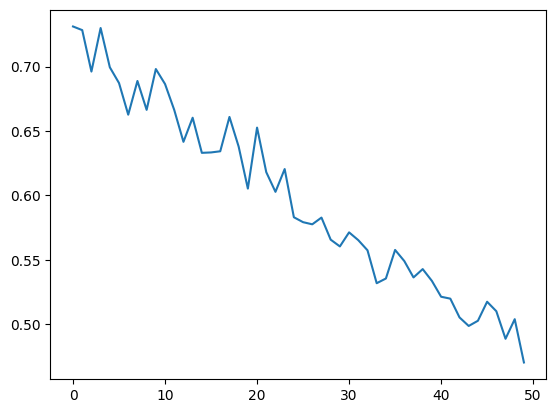

loss :  0.4587564170360565
tp :  17.0
fp :  4.0
tn :  22.0
fn :  2.0
accuracy :  0.8666666746139526
Accuracy on validation set: 0.87
precision :  0.8095238208770752
recall :  0.8947368264198303
auc :  0.9159919023513794
prc :  0.9112653136253357
Epoch 1/50
3/3 - 2s - loss: 0.7604 - tp: 31.0000 - fp: 43.0000 - tn: 41.0000 - fn: 19.0000 - accuracy: 0.5373 - precision: 0.4189 - recall: 0.6200 - auc: 0.6365 - prc: 0.5905 - val_loss: 0.7809 - val_tp: 6.0000 - val_fp: 25.0000 - val_tn: 2.0000 - val_fn: 11.0000 - val_accuracy: 0.1818 - val_precision: 0.1935 - val_recall: 0.3529 - val_auc: 0.1656 - val_prc: 0.2560 - 2s/epoch - 519ms/step
Epoch 2/50
3/3 - 0s - loss: 0.7339 - tp: 12.0000 - fp: 34.0000 - tn: 24.0000 - fn: 19.0000 - accuracy: 0.4045 - precision: 0.2609 - recall: 0.3871 - auc: 0.4091 - prc: 0.2851 - val_loss: 0.7734 - val_tp: 6.0000 - val_fp: 24.0000 - val_tn: 3.0000 - val_fn: 11.0000 - val_accuracy: 0.2045 - val_precision: 0.2000 - val_recall: 0.3529 - val_auc: 0.1819 - val_prc: 0

Epoch 22/50
3/3 - 0s - loss: 0.6694 - tp: 18.0000 - fp: 22.0000 - tn: 36.0000 - fn: 13.0000 - accuracy: 0.6067 - precision: 0.4500 - recall: 0.5806 - auc: 0.6279 - prc: 0.5319 - val_loss: 0.6798 - val_tp: 10.0000 - val_fp: 10.0000 - val_tn: 17.0000 - val_fn: 7.0000 - val_accuracy: 0.6136 - val_precision: 0.5000 - val_recall: 0.5882 - val_auc: 0.6296 - val_prc: 0.5677 - 58ms/epoch - 19ms/step
Epoch 23/50
3/3 - 0s - loss: 0.6432 - tp: 19.0000 - fp: 20.0000 - tn: 38.0000 - fn: 12.0000 - accuracy: 0.6404 - precision: 0.4872 - recall: 0.6129 - auc: 0.6660 - prc: 0.6359 - val_loss: 0.6758 - val_tp: 10.0000 - val_fp: 10.0000 - val_tn: 17.0000 - val_fn: 7.0000 - val_accuracy: 0.6136 - val_precision: 0.5000 - val_recall: 0.5882 - val_auc: 0.6460 - val_prc: 0.5934 - 57ms/epoch - 19ms/step
Epoch 24/50
3/3 - 0s - loss: 0.6417 - tp: 19.0000 - fp: 19.0000 - tn: 39.0000 - fn: 12.0000 - accuracy: 0.6517 - precision: 0.5000 - recall: 0.6129 - auc: 0.7258 - prc: 0.5935 - val_loss: 0.6719 - val_tp: 10.00

Epoch 43/50
3/3 - 0s - loss: 0.5833 - tp: 22.0000 - fp: 12.0000 - tn: 46.0000 - fn: 9.0000 - accuracy: 0.7640 - precision: 0.6471 - recall: 0.7097 - auc: 0.8195 - prc: 0.7713 - val_loss: 0.6024 - val_tp: 12.0000 - val_fp: 7.0000 - val_tn: 20.0000 - val_fn: 5.0000 - val_accuracy: 0.7273 - val_precision: 0.6316 - val_recall: 0.7059 - val_auc: 0.7996 - val_prc: 0.7670 - 59ms/epoch - 20ms/step
Epoch 44/50
3/3 - 0s - loss: 0.5610 - tp: 25.0000 - fp: 12.0000 - tn: 46.0000 - fn: 6.0000 - accuracy: 0.7978 - precision: 0.6757 - recall: 0.8065 - auc: 0.8849 - prc: 0.8477 - val_loss: 0.5991 - val_tp: 12.0000 - val_fp: 7.0000 - val_tn: 20.0000 - val_fn: 5.0000 - val_accuracy: 0.7273 - val_precision: 0.6316 - val_recall: 0.7059 - val_auc: 0.8007 - val_prc: 0.7741 - 60ms/epoch - 20ms/step
Epoch 45/50
3/3 - 0s - loss: 0.5548 - tp: 26.0000 - fp: 12.0000 - tn: 46.0000 - fn: 5.0000 - accuracy: 0.8090 - precision: 0.6842 - recall: 0.8387 - auc: 0.8724 - prc: 0.8805 - val_loss: 0.5957 - val_tp: 12.0000 - 

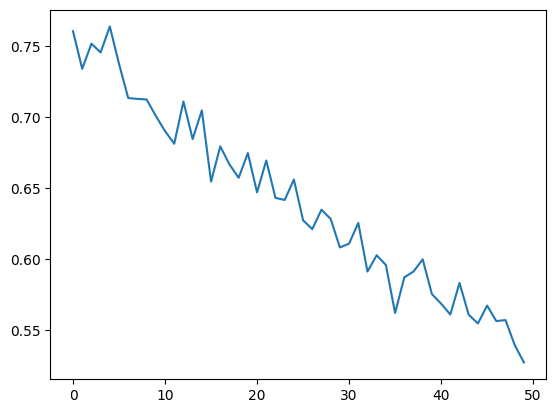

loss :  0.5796660780906677
tp :  13.0
fp :  7.0
tn :  20.0
fn :  4.0
accuracy :  0.75
Accuracy on validation set: 0.75
precision :  0.6499999761581421
recall :  0.7647058963775635
auc :  0.8366013169288635
prc :  0.8036142587661743
Epoch 1/50
3/3 - 2s - loss: 0.6083 - tp: 36.0000 - fp: 20.0000 - tn: 60.0000 - fn: 17.0000 - accuracy: 0.7218 - precision: 0.6429 - recall: 0.6792 - auc: 0.7900 - prc: 0.7409 - val_loss: 0.5043 - val_tp: 12.0000 - val_fp: 2.0000 - val_tn: 30.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9545 - val_precision: 0.8571 - val_recall: 1.0000 - val_auc: 0.9935 - val_prc: 0.9820 - 2s/epoch - 666ms/step
Epoch 2/50
3/3 - 0s - loss: 0.5810 - tp: 24.0000 - fp: 9.0000 - tn: 44.0000 - fn: 12.0000 - accuracy: 0.7640 - precision: 0.7273 - recall: 0.6667 - auc: 0.8226 - prc: 0.7937 - val_loss: 0.4975 - val_tp: 12.0000 - val_fp: 2.0000 - val_tn: 30.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9545 - val_precision: 0.8571 - val_recall: 1.0000 - val_auc: 0.9935 - val_prc: 0.9820 -

Epoch 22/50
3/3 - 0s - loss: 0.5060 - tp: 28.0000 - fp: 7.0000 - tn: 46.0000 - fn: 8.0000 - accuracy: 0.8315 - precision: 0.8000 - recall: 0.7778 - auc: 0.8847 - prc: 0.8960 - val_loss: 0.4149 - val_tp: 12.0000 - val_fp: 2.0000 - val_tn: 30.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9545 - val_precision: 0.8571 - val_recall: 1.0000 - val_auc: 0.9961 - val_prc: 0.9896 - 54ms/epoch - 18ms/step
Epoch 23/50
3/3 - 0s - loss: 0.4882 - tp: 31.0000 - fp: 5.0000 - tn: 48.0000 - fn: 5.0000 - accuracy: 0.8876 - precision: 0.8611 - recall: 0.8611 - auc: 0.9497 - prc: 0.9290 - val_loss: 0.4115 - val_tp: 12.0000 - val_fp: 3.0000 - val_tn: 29.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9318 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 0.9961 - val_prc: 0.9896 - 57ms/epoch - 19ms/step
Epoch 24/50
3/3 - 0s - loss: 0.5169 - tp: 27.0000 - fp: 6.0000 - tn: 47.0000 - fn: 9.0000 - accuracy: 0.8315 - precision: 0.8182 - recall: 0.7500 - auc: 0.8991 - prc: 0.8436 - val_loss: 0.4080 - val_tp: 12.00

Epoch 43/50
3/3 - 0s - loss: 0.4540 - tp: 28.0000 - fp: 6.0000 - tn: 47.0000 - fn: 8.0000 - accuracy: 0.8427 - precision: 0.8235 - recall: 0.7778 - auc: 0.9109 - prc: 0.9018 - val_loss: 0.3498 - val_tp: 12.0000 - val_fp: 3.0000 - val_tn: 29.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9318 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 0.9961 - val_prc: 0.9896 - 58ms/epoch - 19ms/step
Epoch 44/50
3/3 - 0s - loss: 0.4656 - tp: 29.0000 - fp: 6.0000 - tn: 47.0000 - fn: 7.0000 - accuracy: 0.8539 - precision: 0.8286 - recall: 0.8056 - auc: 0.8981 - prc: 0.8524 - val_loss: 0.3473 - val_tp: 12.0000 - val_fp: 3.0000 - val_tn: 29.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9318 - val_precision: 0.8000 - val_recall: 1.0000 - val_auc: 0.9961 - val_prc: 0.9896 - 56ms/epoch - 19ms/step
Epoch 45/50
3/3 - 0s - loss: 0.4435 - tp: 32.0000 - fp: 3.0000 - tn: 50.0000 - fn: 4.0000 - accuracy: 0.9213 - precision: 0.9143 - recall: 0.8889 - auc: 0.9423 - prc: 0.9274 - val_loss: 0.3445 - val_tp: 12.00

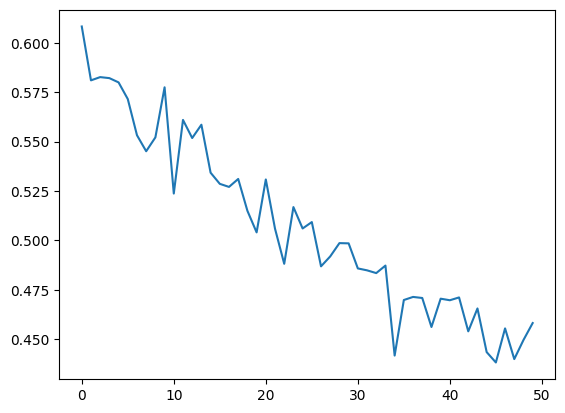

loss :  0.3319433033466339
tp :  12.0
fp :  3.0
tn :  29.0
fn :  0.0
accuracy :  0.9318181872367859
Accuracy on validation set: 0.93
precision :  0.800000011920929
recall :  1.0
auc :  0.9973958730697632
prc :  0.9933298230171204
K-fold cross-validation accuracy: 0.85
1/1 [==============================] - 0s 84ms/step
Accuracy on holdout set: 0.87
Balanced Accuracy on holdout set: 0.86

Classification Report:

              precision    recall  f1-score   support

           0      0.889     0.889     0.889         9
           1      0.833     0.833     0.833         6

    accuracy                          0.867        15
   macro avg      0.861     0.861     0.861        15
weighted avg      0.867     0.867     0.867        15



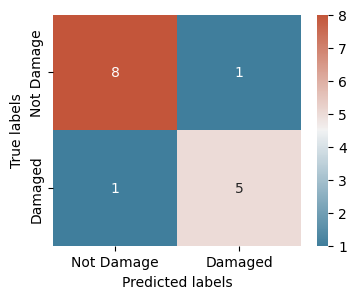

True Positive(TP)  =  5
False Positive(FP) =  1
True Negative(TN)  =  8
False Negative(FN) =  1
Accuracy of the binary classifier = 0.867


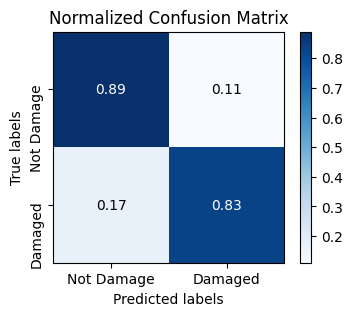

In [18]:
results = []

for train_index, val_index in kf.split(X_train_scaled):
    # split the dataset into training and validation sets for this fold
    X_train_kf, X_val_kf = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model = Baseline(input_dim)
    
    history = model.train(X_train_kf, y_train_kf, X_val_kf, y_val_kf, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()
    
    results_m = model.evaluate(X_val_kf, y_val_kf)
    
    for name, value in zip(model.metrics_names(), results_m):
        print(name, ': ', value)
        if name == 'accuracy':
            accuracy_kf = value
            results.append(accuracy_kf)
            print(f"Accuracy on validation set: {accuracy_kf:.2f}")
    
# Calculate the average accuracy score for the K-fold cross-validation
#print("results",results)
print(f"K-fold cross-validation accuracy: {sum(results) / len(results):.2f}")

y_pred_holdout = model.predict(X_holdout_scaled)
accuracy_holdout = accuracy_score(np.round(y_holdout), np.round(y_pred_holdout))
print(f"Accuracy on holdout set: {accuracy_holdout:.2f}")

balanced_accuracy_holdout = balanced_accuracy_score(np.round(y_holdout), np.round(y_pred_holdout))
print(f"Balanced Accuracy on holdout set: {balanced_accuracy_holdout:.2f}")

print("\nClassification Report:\n")
print(classification_report(np.round(y_holdout), np.round(y_pred_holdout), digits = 3))

cm = confusion_matrix(np.round(y_holdout), np.round(y_pred_holdout))
heat_map(cm)
TN, FP, FN, TP = confusion_matrix(np.round(y_holdout), np.round(y_pred_holdout)).ravel()
print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP + TN) / (TP + FP + TN + FN)
print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

heat_map_normalized(np.round(y_holdout), np.round(y_pred_holdout))

In [19]:
# Calculate performance metrics
accuracy = accuracy_score(np.round(y_holdout), np.round(y_pred_holdout)) * 100
balanced_accuracy = balanced_accuracy_score(np.round(y_holdout), np.round(y_pred_holdout)) * 100
auc = roc_auc_score(np.round(y_holdout), np.round(y_pred_holdout))
precision = precision_score(np.round(y_holdout), np.round(y_pred_holdout))
recall = recall_score(np.round(y_holdout), np.round(y_pred_holdout))
f1 = f1_score(np.round(y_holdout), np.round(y_pred_holdout))

# Print results
print(f"Accuracy: {accuracy:.2f}%")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}%")
print(f"AUC: {auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 86.67%
Balanced Accuracy: 86.11%
AUC: 0.86
Precision: 0.83
Recall: 0.83
F1 score: 0.83


In [20]:
#STOP